In [2]:
import ee
import geemap

In [5]:
Map = geemap.Map()

In [6]:
ee.Initialize()

In [7]:
def get_square_roi(lat, lon):
    # Convert the lat-long point to an EE geometry object
    point = ee.Geometry.Point(lon, lat)
    
    # Define the size of the ROI in meters
    roi_size = 1280
    
    # Create a square buffer around the point with the given size
    roi = point.buffer(roi_size/2).bounds().getInfo()['coordinates']
    
    # Define the visualization parameters for the map
    vis_params = {'color': 'red'}
    
    # Create a map centered on the point with the square ROI overlaid
    roi_map = geemap.Map(center=[lat, lon], zoom=15)
    roi_map.addLayer(point, {}, 'Center point')
    roi_map.addLayer(ee.Geometry.Polygon(roi), vis_params, 'ROI')
    
    # Return the square ROI as a list of coordinates
    return roi

In [21]:
roi = get_square_roi(31.8974, 54.3569)
roi = ee.Geometry.Polygon(roi, None, False)
Map = geemap.Map(zoom=12)
Map.addLayer(roi)
Map.centerObject(roi)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [22]:
s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
                .filterDate('2021-07-15', '2021-08-15') \
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10)) \
                .filter(ee.Filter.lt('SNOW_ICE_PERCENTAGE',10)) \
                .filterBounds(roi) \
                .filter(ee.Filter.contains('.geo', roi)) #this line checks if the scene completly covers the roi, which mean roi is in the scene

In [23]:
s2_img = s2.median().clip(roi).multiply(0.0001)
bands = ['B1','B2','B3','B4']
s2_img = s2_img.select(bands)

In [24]:
geemap.download_ee_image(s2_img, "s2.tif",crs='EPSG:3857', scale=10,region = roi)

s2.tif: |          | 0.00/734k (raw) [  0.0%] in 00:00 (eta:     ?)

In [25]:
from skimage import io
import numpy as np
s2_np = io.imread('s2.tif')
print(s2_np.shape)
print(np.min(s2_np),np.max(s2_np))

(152, 151, 4)
0.0437 0.6268


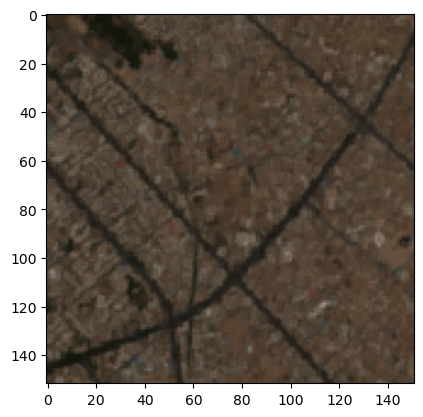

In [26]:
import matplotlib.pyplot as plt
plt.imshow(s2_np[:,:,[3,2,1]])